# Ejercicio 1: Preparación ambiente de trabajo

In [53]:
# importación de modulos

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from calidad_datos import calidad_datos

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 70
warnings.filterwarnings('ignore')

In [54]:
# importación de datos
df = pd.read_csv('default_credit.csv').drop(columns='index')

#### Explorando la distribución de los atributos

In [55]:
# estadisticas iniciales de los atirbutos
calidad_datos(df)

,tipo,nulos,porc_nulos,ceros,porc_ceros,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dist_IQR,limit_inf,limit_sup,outliers
balance,float64,0,0.0,499,0.0499,10000,NaN,NaN,NaN,835.375,483.715,0,481.731,823.637,1166.31,2654.32,684.577,-545.135,2193.17,31
income,float64,0,0.0,0,0.0000,10000,NaN,NaN,NaN,33517,13336.6,771.968,21340.5,34552.6,43807.7,73554.2,22467.3,-12360.4,77508.6,0
default,object,0,0.0,0,0.0000,10000,2,No,9667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
student,object,0,0.0,0,0.0000,10000,2,No,7056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


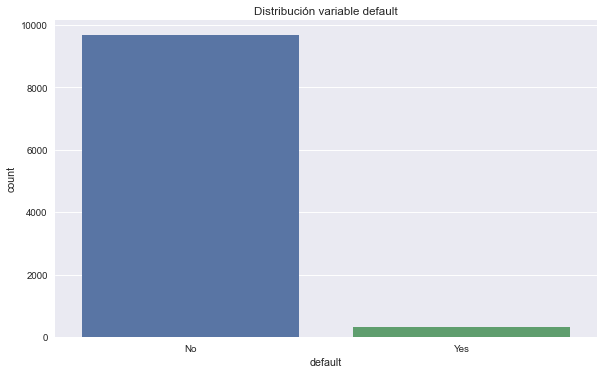

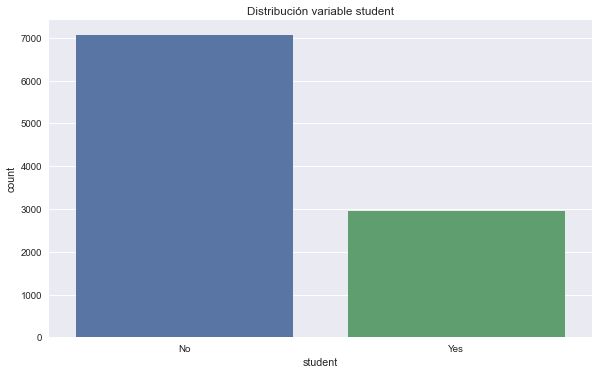

In [56]:
for i, col in enumerate(df.iloc[:, :2].columns):
    sns.countplot(x=df[col])
    plt.title(f'Distribución variable {col}')
    plt.show()

A partir de los resultados anteriores identificamos que tanto la variable objetivo "default" como "student" se encuentran desbalanceadas.

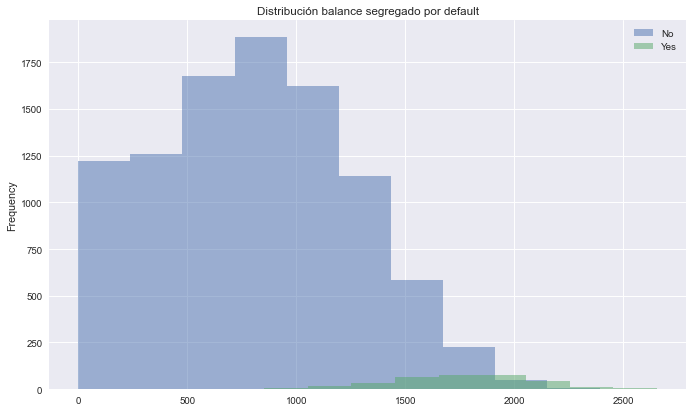

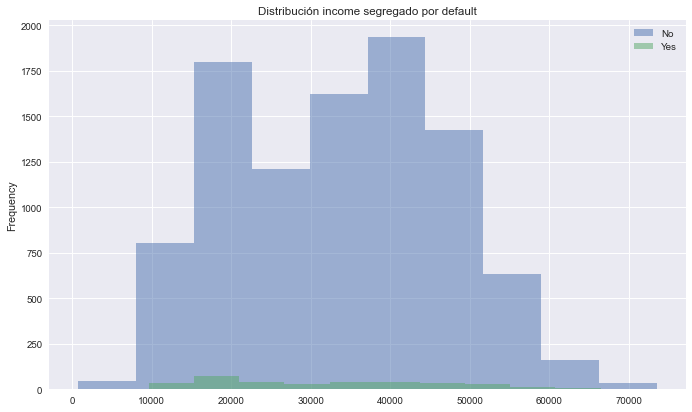

In [57]:
for i, col in enumerate(df.iloc[:, 2:].columns):
    df.groupby('default')[col].plot(kind='hist', alpha=.5)
    plt.legend(df['default'].unique())
    plt.title(f'Distribución {col} segregado por default')
    plt.tight_layout()
    plt.show()

A partir de los resultados anteriores:
* Existe un menor saldo de crédito en cuentas de quienes entraron en morosidad
* El ingreso aparenta distribuirse de forma normal 

# Ejercicio 2: Modelo base

In [58]:
# transformando atributos no numéricos a numéricos
df['default'] = LabelEncoder().fit_transform(df['default'])
df['student'] = LabelEncoder().fit_transform(df['student'])

In [59]:
# conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'student':'income'], df['default'], test_size=.33, random_state=9915)

#### Modelo Linear Discriminante

In [60]:
# ajustamos el modelo
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [61]:
# metricas de desempeño
yhat = lda_model.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3172
           1       0.87      0.20      0.33       128

    accuracy                           0.97      3300
   macro avg       0.92      0.60      0.66      3300
weighted avg       0.96      0.97      0.96      3300



Como resultado:

* Nuestro modelo presenta un alto accuracy general (97%)
* El valor del accuracy se debe principalmente a que estimamos con gran precision a quienes no son morosos (98%)
* El modelo no sabe predecir con exactitud los clientes morosos (f1: 33%)

# Ejercicio 3: Refactorización 1 - información a priori

#### 3.1 Asumamos que hay un 50/50 de morosos y no morosos

In [62]:
lda_model_50 = LinearDiscriminantAnalysis(priors=[50, 50])
lda_model_50.fit(X_train, y_train)

LinearDiscriminantAnalysis(priors=[50, 50])

In [63]:
# metricas de desempeño
yhat_50 = lda_model_50.predict(X_test)
print(classification_report(y_test, yhat_50))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      3172
           1       0.19      0.90      0.32       128

    accuracy                           0.85      3300
   macro avg       0.59      0.87      0.62      3300
weighted avg       0.96      0.85      0.89      3300



Resultados:

* El accuracy disminuye en 5 puntos; echo que es de notar inicialmente ya que las clases no se distribuyen de forma simétrica
* Tanto precision como recall disminuyen, especificando que la capacidad predictiva de nuestro modelo empeora

#### 3.2 Asumamos que hay un 60/40 de morosos y no morosos

In [64]:
lda_model_60 = LinearDiscriminantAnalysis(priors=[40, 60])
lda_model_60.fit(X_train, y_train)

LinearDiscriminantAnalysis(priors=[40, 60])

In [65]:
# metricas de desempeño
yhat_60 = lda_model_60.predict(X_test)
print(classification_report(y_test, yhat_60))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      3172
           1       0.16      0.92      0.27       128

    accuracy                           0.80      3300
   macro avg       0.58      0.86      0.58      3300
weighted avg       0.96      0.80      0.86      3300



Resultados:

* El accuracy disminuye considerablemente a 80%, ya que el estado de moroso lo tiene la minoría de las observaciones, y estamos entregandole un mayor peso
* Tanto precision como recall disminuyen. La predicción ha empeorado

# Ejercicio 4: Refactorización 2 - oversampling

In [1]:
from imblearn.over_sampling import SMOTE

NOTA: no pude instalar el paquete, me marcaba un error con un modulo de Scikit-learn que no pude solucionar.

# Ejercicio 5: Refactorización 3 - QDA

In [76]:
# ajustamos el modelo
cda_model = QuadraticDiscriminantAnalysis()
cda_model.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [77]:
# predecimos
yhat_cda = cda_model.predict(X_test)
print(classification_report(y_test, yhat_cda))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3172
           1       0.81      0.20      0.33       128

    accuracy                           0.97      3300
   macro avg       0.89      0.60      0.65      3300
weighted avg       0.96      0.97      0.96      3300



Resultados:

* El accuracy se mantiene constante al modelo lineal (97%)
* También se mantiene constante el f1-scoe

#### Mejor modelo

Dado que no pudimos implementar el oversampling, entonces es indiferente el uso de LDA o CDA sobre los datos base.